# Intel Tech Week workshop: Introduction to Deep Learning with Python
### Itay lieder

## Keras
Keras is one of the most popular and powerful TensorFlow extension libraries. In 2017 Keras gained official Google support, and has been officially into integrated into tf.

It can run with both tensorflow backend and theano (tf's arch-nemesis) backend

Keras has two main types of models to choose —Sequential and functional. The sequential type is designed for simple architectures, where we just want to stack layers in a linear fashion. The functional API can support more general models with a diverse layer structure such as multi-output models or a directed acyclic graph. 

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


### Dense layer
Dense" is a fully connected layer where the first argument denotes the number of output units and the input shape is the shape of the input (in this example the weight matrix would be of size 784x64). 



# Functional model
The main difference here is that we first define our input and output, and only then instantiate the model

Create an input Tensor according to its shape

~~~python 
inputs = Input(shape=(784,))
~~~

Define model

~~~python 
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
~~~

And now instantiate the model, passing both inputs and outputs to "Model".

~~~python 
model = Model(inputs=inputs, oprintutputs=outputs)

from keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.fit(x_train, y_train, epochs=10, batch_size=64,
          callbacks=[TensorBoard(log_dir='/models/autoencoder',)
          early_stop])

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
classes = model.predict(x_test, batch_size=64)
~~~

In [2]:
import os
# for handeling data frames
import pandas as pd

# for numerical computations
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(tf.__version__)
print(tf.test.is_gpu_available())


2.0.0
False


# MNIST
The MNIST (Mixed National Institue of Standards and Technology) handwritten digits dataset is one of the most researched datasets in image processing and machine learning, and has played an important role in the development of artificial neural networks.

Our first example will be a simple softmax-regression model on the raw pixels of the digit images. First, let's take a look at the data!

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(X_train.shape,  y_train.shape, X_test.shape, y_test.shape))

num_classes = len(set(y_train))

X_train: (60000, 28, 28), y_train: (60000,), X_test: (10000, 28, 28), y_test: (10000,)


### Plot samples (features)

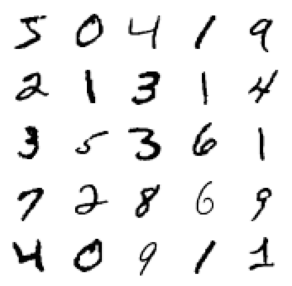

In [5]:
f, axarr = plt.subplots(5,5,figsize=[5,5])
for i in range(25):
    ax = axarr[int(i/5), int(i%5)]
    ax.imshow(X_train[i,:], cmap='Greys')
    ax.axis("off")
plt.show()

### Normalize input to range between 0-1

In [6]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

### Reshape samples to be represented as 1D vectors

In [7]:
X_train = np.reshape(X_train, [X_train.shape[0], 784])
X_test = np.reshape(X_test, [X_test.shape[0], 784])
print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(X_train.shape,  y_train.shape, X_test.shape, y_test.shape))

X_train: (60000, 784), y_train: (60000,), X_test: (10000, 784), y_test: (10000,)


### Plot reshaped samples

In [8]:
X_train.shape

(60000, 784)

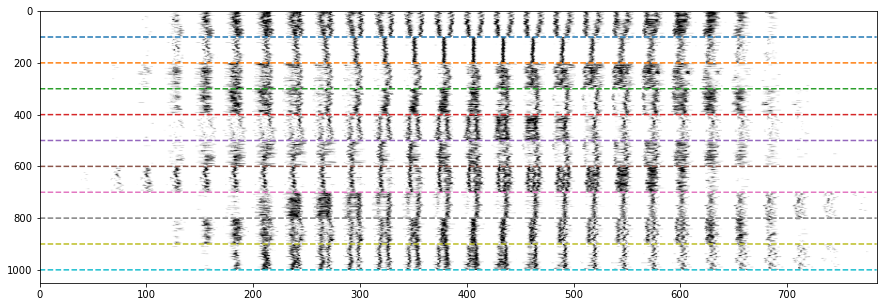

In [10]:
idx_lists = [np.where(i == y_train)[0] for i in set(y_train)]
concat_plot = np.vstack([X_train[idx[:100],:] for idx in idx_lists])
plt.figure(figsize=[15,5])
plt.imshow(concat_plot, aspect='auto', cmap='Greys')
xx = np.linspace(0,784,10000)
for i in range(10):
    yy = np.ones_like(xx)*100*(i+1)
    plt.plot(xx,yy,'--')
plt.xlim([0,784])
# plt.axis("off")
plt.show()

### Shuffle (randomize) samples

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Create 1-hot encoding for each label vector (transforming it to 2D matrix)

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train_khot = enc.fit_transform([[i] for i in y_train]).A
y_test_khot = enc.fit_transform([[i] for i in y_test]).A

### Train a base-line state-of-the-art machine learning algorithm (XGBOOST - gradient boosting)

In [13]:
# import xgboost as xgb
# import time

# start = time.time()
# model=xgb.XGBClassifier(objective ="multi:softmax", colsample_bytree = 0.8, learning_rate = 0.1,
#                 max_depth = 6, alpha = .8, n_estimators = 10, num_class = 10, subsample = 0.8, eta = 0.08)
# model.fit(X_train, y_train)
# print(time.time() - start)

# model.score(X_test,y_test)

### XGBOOST results: accuracy = ~.92

# Softmax classification with Neural Networks
Put simply, the softmax regression model will figure out for each pixel in the image, which digits tend to have high (or low) values in that location. For instance, the center of the image will tend to be white for zeros, but black for sixes. Thus, a black pixel in the center of an image will be evidence against the image containing a zero, and in favor of it containing a six.

Learning in this model consists of finding weights that tell us how to accumulate evidence for the existence of each of the digits. With softmax regression, we will not use the spatial information in the pixel layout in the image.


### Set hyper-parameters

In [14]:
batch_size = 128
epochs = 5
opt = RMSprop(lr=2e-3, decay=1e-5)
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')
callbacks=[early_stop]

### Define model

In [15]:
# input layer
model_input = Input(shape = [X_train.shape[1]])

# hidden layer
hidden = Dense(128,
                    activation='relu',
                    name='hidden')(model_input)
# fully connected layer
predictions = Dense(num_classes,
                    activation='softmax',
                    name='fc')(hidden)
# intialize model - define inputs and outputs
model = Model(inputs=model_input, outputs=predictions)

# compile model - define loss function and optimization method
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
hidden (Dense)               (None, 128)               100480    
_________________________________________________________________
fc (Dense)                   (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Save model (serialize as JSON)

In [16]:
# Clean up the TF session.
K.clear_session()

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Train model

In [17]:
model.fit(X_train, y_train_khot, epochs=epochs, batch_size = 32, callbacks=callbacks)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.2200 - categorical_accuracy: 0.9353
Epoch 2/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.1047 - categorical_accuracy: 0.9688
Epoch 3/5
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0822 - categorical_accuracy: 0.9774
Epoch 4/5
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0659 - categorical_accuracy: 0.9825
Epoch 5/5
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0571 - categorical_accuracy: 0.9854


### Save learned weights (also serialized)

In [18]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Load model, load weights

In [19]:
# # Clean up the TF session.
# K.clear_session()

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

### Compile loaded model, gather predictions for test set and evaluate accuracy

In [20]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
#                     loss='categorical_crossentropy',
#                     metrics=['categorical_accuracy'])

preds = model.predict(X_test)
print(preds.shape)

y_test_pred = np.argmax(preds, 1) # location of maximum probabilty - predicted class

acc = np.equal(y_test_pred, y_test).mean()

# loss, acc = loaded_model.evaluate(X_test, y_test_khot, num_classes)
print('\nTest accuracy: {0}'.format(acc))

(10000, 10)

Test accuracy: 0.9754


# Which images did we get wrong?
The softmax-regression model gets over 8% of the test-set wrong! Later on when we use CNNs things will look much better... (State of the art systems acheive virtually perfect accuracy on this dataset).

But first let's take a look at which digit images we got right, and which we got wrong. Recall softmax-regression doesn't model the relationship between pixels, but rather considers them independently. Does this explain some of the errors we see?   

### Plot confusion matrix (un-normalized)

In [21]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[ 972,    0,    0,    2,    1,    0,    2,    1,    2,    0],
       [   0, 1123,    3,    0,    0,    0,    3,    0,    6,    0],
       [   5,    1, 1005,    4,    1,    0,    3,    5,    7,    1],
       [   0,    0,    7,  982,    0,   10,    0,    3,    4,    4],
       [   2,    2,    2,    1,  952,    0,    8,    3,    3,    9],
       [   2,    0,    0,    3,    0,  871,    6,    1,    8,    1],
       [   4,    2,    1,    1,    5,    2,  940,    0,    3,    0],
       [   2,    9,   15,    4,    0,    0,    0,  986,    5,    7],
       [   5,    3,    1,    1,    1,    2,    4,    4,  951,    2],
       [   4,    3,    1,    5,    5,    5,    1,    6,    7,  972]],
      dtype=int64)

### Plot again as image (normazlied 0-1)

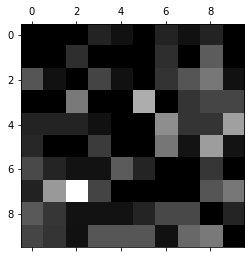

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Investigate confused values

In [23]:
cl_a, cl_b = 3, 5
X_aa = X_test[(y_test == cl_a) & (y_test_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_pred == cl_b)]
reshape = lambda x: np.reshape(x, (x.shape[0], 28, 28))

[X_aa, X_ab, X_ba, X_bb] = [reshape(i) for i in [X_aa, X_ab, X_ba, X_bb]]



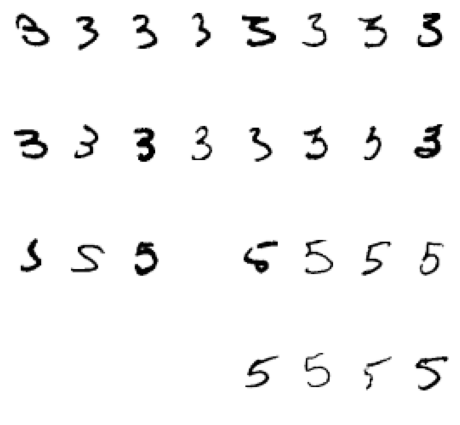

In [24]:
f, axarr = plt.subplots(4,8,figsize=[8,8])
for i in range(8):
    ax = axarr[int(i/4), int(i%4)]
    ax.imshow(X_aa[i,:], cmap='Greys')
    ax.axis("off")
    
for i in range(8):
    ax = axarr[int((i+8)/4), int((i+8)%4)]
    try:
        ax.imshow(X_ba[i,:], cmap='Greys')
    except:
        pass
    ax.axis("off")
    
for i in range(8):
    ax = axarr[int((i)/4), int((i)%4)+4]
    ax.imshow(X_ab[i,:], cmap='Greys')
    ax.axis("off")    
    
for i in range(8):
    ax = axarr[int((i+8)/4), int((i+8)%4)+4]
    ax.imshow(X_bb[i,:], cmap='Greys')
    ax.axis("off")       
    
    
plt.show()

## Parameter optimization with "talos"
### "pip install talos"
### Note that this requires useing a downgraded version of TF - 1.14


### Define parameter dictionary

In [25]:
import talos as ta

p = {'activation':['relu', 'elu'],
     'optimizer': ['Adam', 'nadam'],
     'losses': ['binary_crossentropy'],
     'batch_size': [16, 32],
     'epochs': [1, 3],
      'n_hidden': [32, 64, 128]}

rel_par = ['activation', 'optimizer', 'batch_size', 'epochs', 'n_hidden']

In [27]:
def dnn(x_train, y_train, x_val, y_val, params):

    model_input = Input(shape = [X_train.shape[1]])
    
    hidden = Dense(params['n_hidden'],
                        activation=params['activation'],
                        name='hidden')(model_input)

    predictions = Dense(num_classes,
                        activation='softmax',
                        name='fc')(hidden)
    model = Model(inputs=model_input, outputs=predictions)


    model.compile(optimizer=params['optimizer'],
                        loss='categorical_crossentropy',
                        metrics=['categorical_accuracy'])

    out = model.fit(X_train, y_train_khot, 
                    epochs=params['epochs'], 
                    batch_size = params['batch_size'],
                    validation_data = [x_val, y_val],
                    verbose=0)


    return out, model


df_across_conf = ta.Scan(X_train, y_train_khot, model=dnn, params=p, experiment_name='mnist')



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [11:47<00:00, 14.74s/it]


In [31]:
ta.Evaluate(df_across_conf)

In [32]:
df_data = df_across_conf.data

### Save results dataframe

In [33]:
df_data.to_csv('df_data.csv')
df_data

,start,end,duration,round_epochs,loss,categorical_accuracy,val_loss,val_categorical_accuracy,activation,batch_size,epochs,losses,n_hidden,optimizer
0,06/22/21-161707,06/22/21-161714,7.232634,1,0.315791,0.911100,0.197591,0.942000,relu,16,1,binary_crossentropy,32,Adam
1,06/22/21-161715,06/22/21-161722,7.686002,1,0.327205,0.908400,0.196370,0.942333,relu,16,1,binary_crossentropy,32,nadam
2,06/22/21-161722,06/22/21-161731,8.584074,1,0.273390,0.921533,0.156748,0.952500,relu,16,1,binary_crossentropy,64,Adam
3,06/22/21-161731,06/22/21-161740,9.222237,1,0.265324,0.924750,0.139300,0.961833,relu,16,1,binary_crossentropy,64,nadam
4,06/22/21-161741,06/22/21-161749,8.599643,1,0.231619,0.933317,0.126201,0.962889,relu,16,1,binary_crossentropy,128,Adam
5,06/22/21-161749,06/22/21-161800,10.943090,1,0.231563,0.932850,0.102281,0.969222,relu,16,1,binary_crossentropy,128,nadam
6,06/22/21-161800,06/22/21-161822,21.152775,3,0.133539,0.961217,0.109860,0.966278,relu,16,3,binary_crossentropy,32,Adam
7,06/22/21-161822,06/22/21-161845,23.100333,3,0.140194,0.958133,0.126866,0.961444,relu,16,3,binary_crossentropy,32,nadam
8,06/22/21-161845,06/22/21-161913,28.270073,3,0.095491,0.971333,0.074280,0.976667,relu,16,3,binary_crossentropy,64,Adam
9,06/22/21-161913,06/22/21-161941,27.887490,3,0.092241,0.972317,0.067773,0.979167,relu,16,3,binary_crossentropy,64,nadam


### Load results dataframe

In [34]:
df_data = pd.read_csv('df_data.csv')


## Investigate results

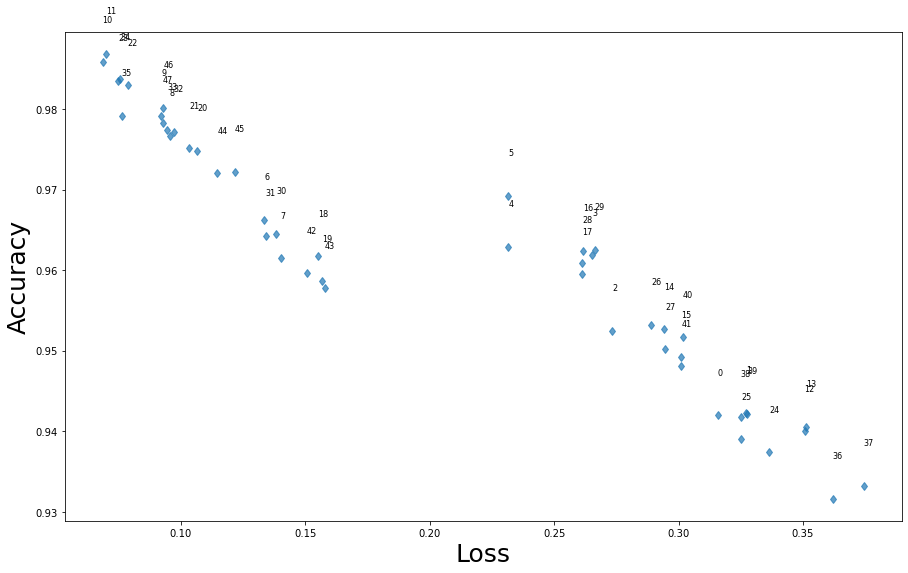

   activation optimizer  n_hidden
0        relu      Adam        32
1        relu     nadam        32
2        relu      Adam        64
3        relu     nadam        64
4        relu      Adam       128
5        relu     nadam       128
6        relu      Adam        32
7        relu     nadam        32
8        relu      Adam        64
9        relu     nadam        64
10       relu      Adam       128
11       relu     nadam       128
12       relu      Adam        32
13       relu     nadam        32
14       relu      Adam        64
15       relu     nadam        64
16       relu      Adam       128
17       relu     nadam       128
18       relu      Adam        32
19       relu     nadam        32
20       relu      Adam        64
21       relu     nadam        64
22       relu      Adam       128
23       relu     nadam       128
24        elu      Adam        32
25        elu     nadam        32
26        elu      Adam        64
27        elu     nadam        64
28        elu 

In [35]:
rel_param = ['activation', 'optimizer', 'n_hidden']


f, ax = plt.subplots(figsize = [15,9])
ax.plot(df_data['loss'], df_data['val_categorical_accuracy'],'d', alpha=.7)
for i in range(len(df_data)):
    ax.text(df_data.iloc[i]['loss'], df_data.iloc[i]['val_categorical_accuracy'] + .005, str(i), fontsize=8)

ax.set_xlabel('Loss', fontsize = 25)    
ax.set_ylabel('Accuracy', fontsize = 25)    

plt.show()
df_data = df_data.set_index(np.arange(len(df_data)))
print(df_data[rel_param])


activation
optimizer
batch_size
epochs
n_hidden
activation
optimizer
batch_size
epochs
n_hidden


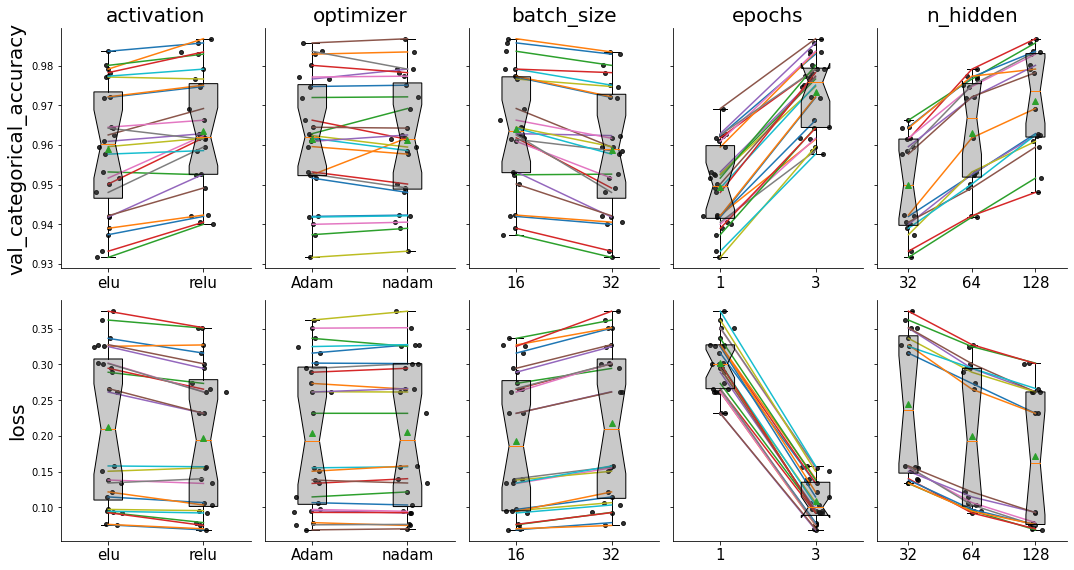

In [36]:
metrics = ['val_categorical_accuracy', 'loss']
f, axarr = plt.subplots(2,len(rel_par), figsize = [15,8], sharey = 'row')
for ii, metric in enumerate(metrics):
    for jj, param in enumerate(rel_par):
        ax = axarr[ii,jj]
        data = []
        X = []
        for i, df in df_data.groupby([param]):
            X.append(i)
            data.append(df[metric])
        print(param)
        xlabel = X
        ylabel = metric
        title = param
        l = len(data)
        noise = 0
        y = np.arange(l)
        bplot1 = ax.boxplot(data ,1, positions=y, vert=1, patch_artist=True, showmeans=True, widths = 0.3)

        noise = []
        ys = []
        for i in range(l):
            ys.append(np.ones_like(data[i])*y[i])
            noise.append(np.random.randn(len(ys[i]))*.07)

        for i in range(l):
            ax.plot(ys[i]+noise[i],data[i],'o',ms=4,color='k',alpha=.8)

        for patch,c in zip(bplot1['boxes'],['lightblue','lightblue', 'lightblue']):
            patch.set_facecolor((.3,.3,.3,.3))

        ax.plot(ys, data, '-')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xticklabels(xlabel)
        if jj == 0:
            ax.set_ylabel(ylabel, fontsize=20)    
        if ii == 0:
            ax.set_title(title, fontsize=20)
        ax.tick_params(axis="x", labelsize=15)
                
plt.tight_layout(pad=1)
plt.show()
# 